In [ ]:
from torchvision import models

inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
for name, module in inception.named_modules():
  print(name)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 140MB/s]



Conv2d_1a_3x3
Conv2d_1a_3x3.conv
Conv2d_1a_3x3.bn
Conv2d_2a_3x3
Conv2d_2a_3x3.conv
Conv2d_2a_3x3.bn
Conv2d_2b_3x3
Conv2d_2b_3x3.conv
Conv2d_2b_3x3.bn
maxpool1
Conv2d_3b_1x1
Conv2d_3b_1x1.conv
Conv2d_3b_1x1.bn
Conv2d_4a_3x3
Conv2d_4a_3x3.conv
Conv2d_4a_3x3.bn
maxpool2
Mixed_5b
Mixed_5b.branch1x1
Mixed_5b.branch1x1.conv
Mixed_5b.branch1x1.bn
Mixed_5b.branch5x5_1
Mixed_5b.branch5x5_1.conv
Mixed_5b.branch5x5_1.bn
Mixed_5b.branch5x5_2
Mixed_5b.branch5x5_2.conv
Mixed_5b.branch5x5_2.bn
Mixed_5b.branch3x3dbl_1
Mixed_5b.branch3x3dbl_1.conv
Mixed_5b.branch3x3dbl_1.bn
Mixed_5b.branch3x3dbl_2
Mixed_5b.branch3x3dbl_2.conv
Mixed_5b.branch3x3dbl_2.bn
Mixed_5b.branch3x3dbl_3
Mixed_5b.branch3x3dbl_3.conv
Mixed_5b.branch3x3dbl_3.bn
Mixed_5b.branch_pool
Mixed_5b.branch_pool.conv
Mixed_5b.branch_pool.bn
Mixed_5c
Mixed_5c.branch1x1
Mixed_5c.branch1x1.conv
Mixed_5c.branch1x1.bn
Mixed_5c.branch5x5_1
Mixed_5c.branch5x5_1.conv
Mixed_5c.branch5x5_1.bn
Mixed_5c.branch5x5_2
Mixed_5c.branch5x5_2.conv
Mixed_5c.bra

In [ ]:
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from IPython.display import display

In [ ]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

Using device:  cuda


In [ ]:
def preprocessing(pil_img, device=device):
  t = transforms.ToTensor()(pil_img).unsqueeze(0).to(device)
  return (t - IMAGENET_MEAN.to(device)) / IMAGENET_STD.to(device)

def deprocessing(tensor):
  t = tensor.detach().cpu() * IMAGENET_STD + IMAGENET_MEAN
  t = t.clamp(0, 1)[0]
  return transforms.ToPILImage()(t)

def load_image(path, max_size=960):
  img = Image.open(path).convert("RGB")
  w, h = img.size
  scale = min(1.0, max_size / max(w, h))
  if scale < 1.0:
    img = img.resize((int(w * scale), int(h * scale)), Image.LANCZOS)
  return img

In [ ]:
class FeatureCatcher:
  """
  To fetch the specific module's activation in InceptionV3 model
  Some Typical layer: Mixed_6e, Mixed_7a, Mixed_7b, Mixed_7c
  """
  def __init__(self, model, layer_names):
    self.model = model
    self.layers_names = set(layer_names)
    self._hooks = []
    self.features = {}

    name_to_module = dict(model.named_modules())
    missing = [n for n in layer_names if n not in name_to_module]
    if missing:
      raise ValueError(f"The follow layers don't exist in InceptionV3: {missing}")
    for name in layer_names:
      m = name_to_module[name]
      h = m.register_forward_hook(self._make_hook(name))
      self._hooks.append(h)

  def _make_hook(self, name):
    def fn(module, inp, out):
      self.features[name] = out
    return fn

  def clear(self):
    self.features = {}

  def close(self):
    for h in self._hooks:
      h.remove()
    self._hooks = []

In [ ]:
layer_weights = {
    "Mixed_6e": 1.5,
    "Mixed_7a": 2.0,
    "Mixed_7b": 2.0,
    "Mixed_7c": 2.0,
}

In [ ]:
def activation_loss(acts_dict, layer_weights=None, channel_norm=True):
  """
  L2 amplification is performed on the captured activations of each layer.
  Optional channel normalization reduces the dominance of certain channels.
  The layer, not in the 'layer_weights', the weigit is 1.0 by default
  """
  loss = 0.0
  for name, a in acts_dict.items():
    w = 1.0 if (layer_weights is None or name not in layer_weights) else layer_weights[name]
    if channel_norm:
      a = a / (a.std(dim=(2, 3), keepdim=True) + 1e-8)
    loss = loss + w * (a ** 2).mean()
  return loss

In [ ]:
def dream_step(img_t, model, catcher, step_size=0.7, jitter=16, tv_weight=0.0):
  """
  The step of Gradient Ascent
  """
  img = img_t.clone().detach().requires_grad_(True)

  ox, oy = np.random.randint(-jitter, jitter+1, size=2)
  img = torch.roll(img, shifts=(int(oy), int(ox)), dims=(2, 3))

  catcher.clear()
  _ = model(img)
  loss = activation_loss(catcher.features, layer_weights=layer_weights, channel_norm=True)

  if tv_weight > 0:
    tv = (
        img[:, :, :, 1:] - img[:, :, :, :-1]
    ).abs().mean() + (
        img[:, :, 1:, :] - img[:, :, :-1, :]
    ).abs().mean()
  grad, = torch.autograd.grad(loss, img)

  img = torch.roll(img, shifts=(-int(oy), -int(ox)), dims=(2, 3))
  grad = torch.roll(grad, shifts=(-int(oy), -int(ox)), dims=(2, 3))

  g = grad / (grad.abs().mean() + 1e-8)
  img = img_t + step_size * g
  return img.detach(), float(loss.item())


In [ ]:
def deep_dream(
    pil_img, model, catcher, device=device, octaves=4, octave_scale=1.4,
    iters_per_octave=30, step_size=0.7, jitter=16, tv_weight=0.0,
    verbose=True, MIN_SIDE=75
):
  base = pil_img
  if min(base.size) < MIN_SIDE:
    w, h = base.size
    scale = MIN_SIDE / min(w, h)
    base = base.resize((int(w * scale), int(h * scale)), Image.LANCZOS)

  w0, h0 = base.size

  max_pow = np.log(min(w0, h0) / MIN_SIDE) / np.log(octave_scale)
  safe_octaves = int(np.floor(max_pow)) + 1
  if safe_octaves < 1:
    safe_octaves = 1
  if octaves > safe_octaves:
    if verbose:
      print(
          f"[Info] The ovtaves limit from {octaves} to {safe_octaves}, that ensure the minimum edge >= {MIN_SIDE} px."
      )
    octaves = safe_octaves

  sizes = [
      (int(w0 / (octave_scale ** i)), int(h0 / (octave_scale ** i)))
      for i in range(octaves)
  ]
  sizes = list(reversed(sizes))

  # Security
  sizes = [(max(w, MIN_SIDE), max(h, MIN_SIDE)) for (w, h) in sizes]

  current = base
  for io, (w, h) in enumerate(sizes):
    current = current.resize((w, h), Image.LANCZOS)
    img_t = preprocessing(current, device)

    for t in range(iters_per_octave):
      img_t, cur_loss = dream_step(
          img_t, model, catcher, step_size=step_size, jitter=jitter, tv_weight=tv_weight
      )
      if verbose and (t+1) % 10 == 0:
        print(f"Octave {io+1}/{len(sizes)} | iter {t+1:02d}/{iters_per_octave} | loss: {cur_loss:.4f}")

    current = deprocessing(img_t)
  return current

In [ ]:
inception = models.inception_v3(
    weights=models.Inception_V3_Weights.IMAGENET1K_V1
).to(device).eval()

for p in inception.parameters():
  p.requires_grad_(False)

# Recommand Mixed_* layers
dream_layers = [
    "Mixed_5b", "Mixed_5c", "Mixed_5d",
    "Mixed_6a", "Mixed_6b", "Mixed_6c", "Mixed_6d", "Mixed_6e",
    "Mixed_7a", "Mixed_7b", "Mixed_7c"
]
catcher = FeatureCatcher(inception, dream_layers)
print("Dream layers:", dream_layers)

Dream layers: ['Mixed_5b', 'Mixed_5c', 'Mixed_5d', 'Mixed_6a', 'Mixed_6b', 'Mixed_6c', 'Mixed_6d', 'Mixed_6e', 'Mixed_7a', 'Mixed_7b', 'Mixed_7c']


[Info] The ovtaves limit from 4 to 3, that ensure the minimum edge >= 75 px.


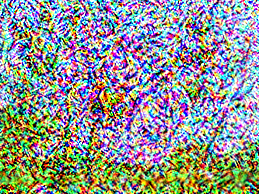

Saved to: dream.jpg


In [ ]:
in_path = "1.jpeg"
out_path = "dream.jpg"

max_size = 960
octaves = 4
octave_scale = 1.4
iters_per_oct = 5

step_size = 0.4
jitter = 16
tv_weight = 5e-4

img = load_image(in_path, max_size=max_size)

result = deep_dream(
    img, inception, catcher, device=device, octaves=octaves,
    octave_scale=octave_scale, iters_per_octave=iters_per_oct,
    step_size=step_size, jitter=jitter, tv_weight=tv_weight, verbose=True
)

result.save(out_path)
display(result)
print("Saved to:", out_path)